## Import and data loader

In [279]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as TF
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

def load_polar(file):
    lidar = np.load(file)
    lidar = from_polar(preprocess(lidar).astype('float32'))
    
    length,_,_,_ = lidar.size()
    lidar = lidar.numpy()
    for n in range(length):
        for c in range(3):
            x = lidar[n,c,:,:]
            lidar[n,c,:,:] = np.interp(x, (x.min(), x.max()), (-1, 1))
    return torch.Tensor(lidar)
    #float32 should be used, but reducing for rapid prototyping



## Load Caccia helper functions

In [213]:

def from_polar(velo):
    angles = np.linspace(0, np.pi * 2, velo.shape[-1])
    dist, z = velo[:, 0], torch.Tensor(velo[:, 1])
    x = torch.Tensor(np.cos(angles)).unsqueeze(0).unsqueeze(0) * dist
    y = torch.Tensor(np.sin(angles)).unsqueeze(0).unsqueeze(0) * dist
    out = torch.stack([x,y,z], dim=1)
    return out

def to_polar(velo):
    if len(velo.shape) == 4:
        velo = velo.permute(1, 2, 3, 0)
    if velo.shape[2] > 4:
        assert velo.shape[0] <= 4
        velo = velo.permute(1, 2, 0, 3)
        switch=True
    else:
        switch=False
    # assumes r x n/r x (3,4) velo
    dist = torch.sqrt(velo[:, :, 0] ** 2 + velo[:, :, 1] ** 2)
    # theta = np.arctan2(velo[:, 1], velo[:, 0])
    out = torch.stack([dist, velo[:, :, 2]], dim=2)
    if switch:
        out = out.permute(2, 0, 1, 3)
    if len(velo.shape) == 4: 
        out = out.permute(3, 0, 1, 2)
    return out

def to_polar_np(velo):
    if len(velo.shape) == 4:
        velo = velo.transpose(1, 2, 3, 0)
    if velo.shape[2] > 4:
        assert velo.shape[0] <= 4
        velo = velo.transpose(1, 2, 0, 3)
        switch=True
    else:
        switch=False
    # assumes r x n/r x (3,4) velo
    dist = np.sqrt(velo[:, :, 0] ** 2 + velo[:, :, 1] ** 2)
    # theta = np.arctan2(velo[:, 1], velo[:, 0])
    out = np.stack([dist, velo[:, :, 2]], axis=2)
    if switch:
        out = out.transpose(2, 0, 1, 3)
    if len(velo.shape) == 4: 
        out = out.transpose(3, 0, 1, 2)
    return out

def remove_zeros(pc):
    xx = torch.FloatTensor(pc)
    if xx.dim() == 3: 
        xx = xx.unsqueeze(0)

    iters = 0
    pad = 2
    ks = 5
    while (xx[:, 0] == 0).sum() > 0 : 
        if iters  > 100:
            raise ValueError()
            ks += 2
            pad += 1
        
        mask = (xx[:, 0] == 0).unsqueeze(1).float()
        out_a = F.max_pool2d(xx[:, 0], ks, padding=pad, stride=1)
        out_b = -F.max_pool2d(-xx[:, 1], ks, padding=pad, stride=1)
        #out_b_ = (xx[:, 1]).min(dim=-1, keepdim=True)[0].expand_as(out_b)
        #out_b = torch.cat([out_b_[:, :10], out_b[:, 10:]], dim=1)
        out_b = out_b.expand_as(out_a)
        out = torch.stack([out_a, out_b], dim=1)
        mask = (xx[:, 0] == 0).unsqueeze(1)
        mask = mask.float()
        xx = xx * (1 - mask) + (mask) * out
        iters += 1

    return xx.cpu().data.numpy()


def preprocess(dataset):
    min_a, max_a = -41.1245002746582,   36.833248138427734
    min_b, max_b = -25.833599090576172, 30.474000930786133
    min_c, max_c = -2.3989999294281006, 0.7383332848548889
    dataset = dataset[:, 5:45]

    mask = np.maximum(dataset[:, :, :, 0] < min_a, dataset[:, :, :, 0] > max_a)
    mask = np.maximum(mask, np.maximum(dataset[:, :, :, 1] < min_b, dataset[:, :, :, 1] > max_b))
    mask = np.maximum(mask, np.maximum(dataset[:, :, :, 2] < min_c, dataset[:, :, :, 2] > max_c))
    
    dist = dataset[:, :, :, 0] ** 2 + dataset[:, :, :, 1] ** 2
    mask = np.maximum(mask, dist < 7)

    dataset = dataset * (1 - np.expand_dims(mask, -1))
    dataset /= np.absolute(dataset).max()

    dataset = to_polar_np(dataset).transpose(0, 3, 1, 2)
    previous = (dataset[:, 0] == 0).sum()

    remove = []
    for i in range(dataset.shape[0]):
        #print('processing {}/{}'.format(i, dataset.shape[0]))
        try:
            pp = remove_zeros(dataset[i]).squeeze(0)
            dataset[i] = pp
        except:
            print('removing %d' % i)
            remove += [i]

    for i in remove:
        dataset = np.concatenate([dataset[:i-1], dataset[i+1:]], axis=0)

    return dataset[:, :, :, ::2]


## Visualize

removing 42
removing 153
(152, 3, 40, 256)


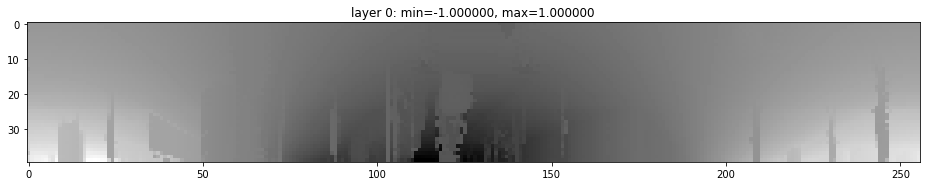

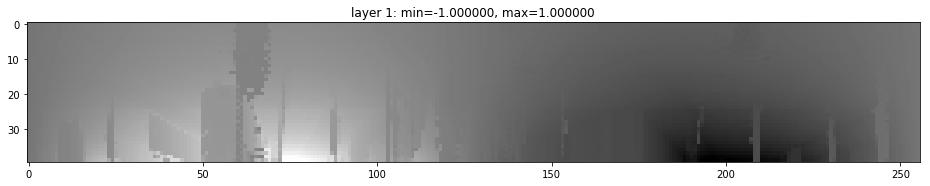

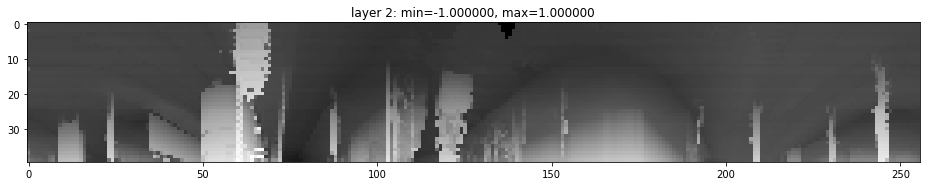

In [298]:
import matplotlib.pyplot as plt
from matplotlib import cm
lidar = load_polar('lidar_val.npz').numpy()
#lidar = np.clip(lidar, -.1,.1)
print(np.shape(lidar))
for i in range(3):
    #lidar[:,i] = np.clip(lidar[:,i], -.5/(i+1), .5/(i+1))
    title = 'layer %d: min=%f, max=%f'%(i,np.min(lidar[:,i,:,:]),np.max(lidar[:,i,:,:]))
    plt.imshow(lidar[0,i,:,:], cmap=cm.gray)
    plt.title(title)
    plt.gcf().set_size_inches(16,16)
    plt.show()
del lidar #free memory space

## VAE process and loss

In [301]:
class VAE_encode(nn.Module):
    def __init__(self, batch_size): #specify parameter functions to train 
        super(VAE_encode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] (creates many layers)
        #layer 2, to [10, 128, 10, 64]  (pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  (pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (compression [do we want this?])
        
        #ENCODER1
        nc=3
        ndf=64
        nz = 200
        encode1_layers = []
        encode1_layers += [nn.Conv2d(nc,ndf, 4, 2, 1, bias=False)]
        encode1_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode1_layers += [nn.Conv2d(ndf,ndf*2, 4, 2, 1, bias=False)]
        self.encoder1 = nn.Sequential(*encode1_layers)
        
        #ENCODER2
        encode2_layers = []
        encode2_layers += [nn.BatchNorm2d(ndf*2)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf*2,ndf*4, 4, 2, 1, bias=False)]
        
        encode2_layers += [nn.BatchNorm2d(ndf*4)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 4, ndf * 8, (3,4), 2, (0,1), bias=False)]
        
        encode2_layers += [nn.BatchNorm2d(ndf*8)]
        encode2_layers += [nn.LeakyReLU(0.2, inplace=True)]
        encode2_layers += [nn.Conv2d(ndf * 8,nz*2, (2,16), 1, 0, bias=False)]
        self.encoder2 = nn.Sequential(*encode2_layers)  
        
        self.findmu  = nn.Linear(nz,nz)
        self.findvar = nn.Linear(nz,nz)
    
    def forward(self, x, batch_size, training): #full vae forward path
        #print('encoding to amrr')
        x_amrr = self.encoder1(x)
        #print('encoding to z')
        mu,logvar = torch.chunk(self.encoder2(x_amrr),2,dim=1)
        n,c,h,w = mu.size()
        mu = self.findmu(mu.view(n,-1)).unsqueeze(-1).unsqueeze(-1)
        logvar = self.findvar(logvar.view(n,-1)).unsqueeze(-1).unsqueeze(-1)
        #print('reparameterizing')
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        if training==1:
            z = eps.mul(std).add_(mu)
        else:
            z = mu
        return z, mu, logvar 


class VAE_decode(nn.Module):
    def __init__(self, batch_size): #specify parameter functions to train 
        super(VAE_decode, self).__init__(),
        #instantiate,[10, 3,   40, 256]
        
        #layer 1, to [10, 64,  20, 128] (creates many layers)
        #layer 2, to [10, 128, 10, 64]  (pulls content to new layers)
        #layer 3, to [10, 256,  5, 32]  (pulls content to new layers)
        
        #layer 4, to [10, 512,  2, 16]  (further reduces content for final layer)
        #layer 5, to [10, 100,  1, 1]   (compression [do we want this?])
                
        #DECODER
        nz = 200 
        ngf = 64 
        nc = 3
        decode_layers = []
        decode_layers += [nn.ConvTranspose2d(nz,ngf*8,(2,16),1,0,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*8)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 8, ngf * 4,(3,4),2,(0,1),bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*4)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 4, ngf * 2,4, 2, 1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*2)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf * 2, ngf * 1,4, 2, 1,bias=False)]
        decode_layers += [nn.BatchNorm2d(ngf*1)]
        decode_layers += [nn.ReLU(True)]
        
        decode_layers += [nn.ConvTranspose2d(ngf, nc,4, 2, 1,bias=False)]
        decode_layers += [nn.Tanh()]
        self.decoder = nn.Sequential(*decode_layers)
        
    
    def forward(self, z, batch_size): #full vae forward path
        #print('decoding')
        x_pred = self.decoder(z)
        return x_pred
        
def KLloss(mu, logvar):
    return torch.sum(-0.5*torch.sum(1+logvar-mu.pow(2)-logvar.exp(),dim=-1))

def MSEloss(sample, data):
    l,c,h,w = sample.size()
    x = sample.view(l,c,-1).transpose(0,1)
    y = data.view(l,c,-1).transpose(0,1)
    
    #sum of mean square errors for each channel
    a = torch.sum(torch.sum((x[0]-y[0])**2,dim=-1))
    b = torch.sum(torch.sum((x[1]-y[1])**2,dim=-1))
    c = torch.sum(torch.sum((x[2]-y[2])**2,dim=-1))
    #print('a: %.2f, b: %.2f, c: %.2f'%(a,b,c))
    mse_loss = a+b+1.5*c
    
    ''' 
    a=np.array([[1, 0, -1],[2,0,-2],[1,0,-1]])
    weight=torch.from_numpy(a).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_x = F.conv2d(sample, weight)
    data_x  = F.conv2d(data, weight)
    
    b=np.array([[1, 2, 1],[0,0,0],[-1,-2,-1]])
    weight=torch.from_numpy(b).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1)
    sample_y = F.conv2d(sample, weight)
    data_y  = F.conv2d(data, weight)

    sample_grad=torch.sqrt(torch.pow(sample_x,2)+ torch.pow(sample_y,2))
    data_grad=torch.sqrt(torch.pow(data_x,2)+ torch.pow(data_y,2))
    
    edge_loss = F.mse_loss(sample_grad,data_grad)
    '''
    return mse_loss
        
    
    

## Training

loading data
removing 42
removing 153
 


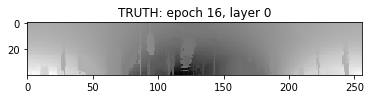

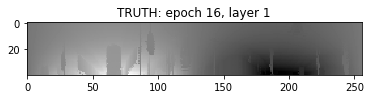

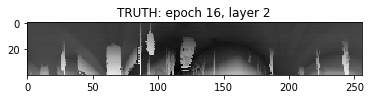



EPOCH : 0




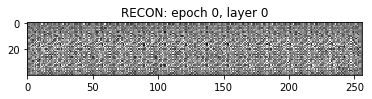

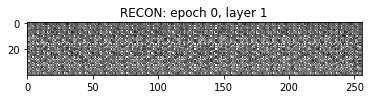

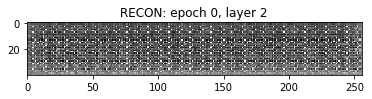



EPOCH : 1




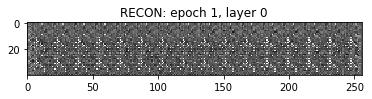

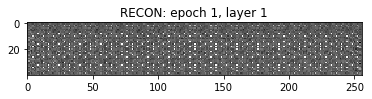

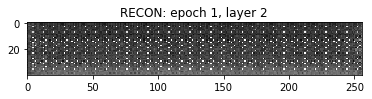



EPOCH : 2




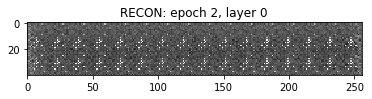

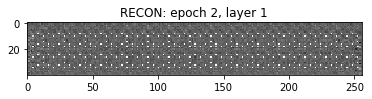

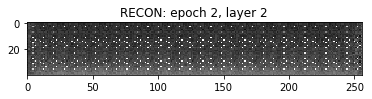



EPOCH : 3




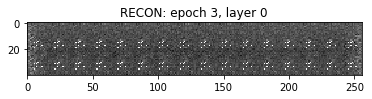

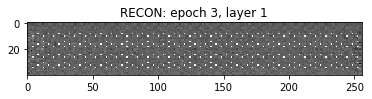

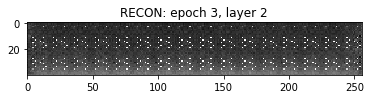



EPOCH : 4




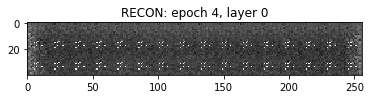

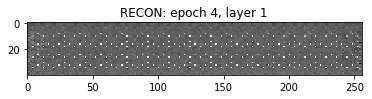

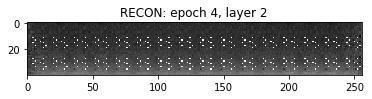



EPOCH : 5




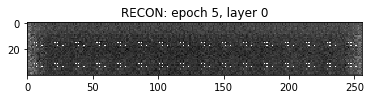

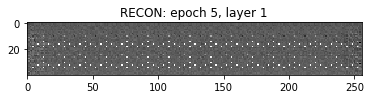

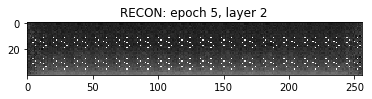



EPOCH : 6




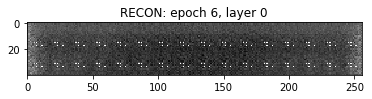

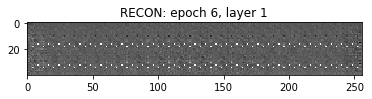

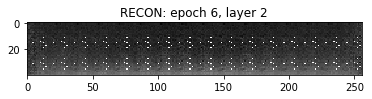



EPOCH : 7




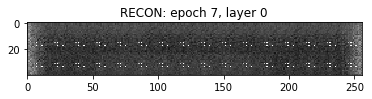

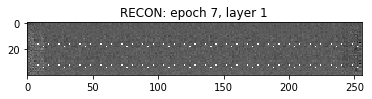

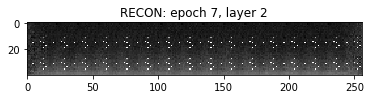



EPOCH : 8




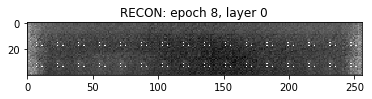

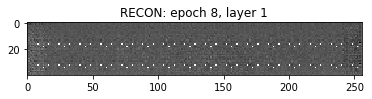

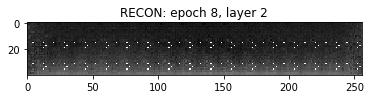



EPOCH : 9




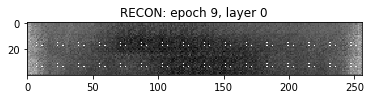

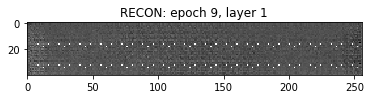

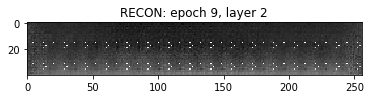



EPOCH : 10




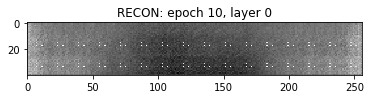

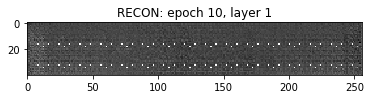

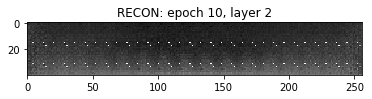



EPOCH : 11




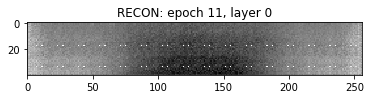

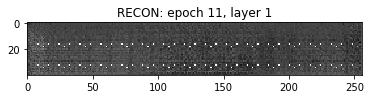

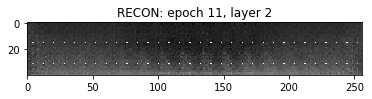



EPOCH : 12




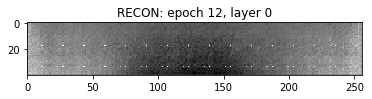

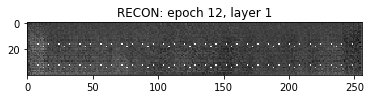

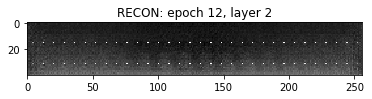



EPOCH : 13




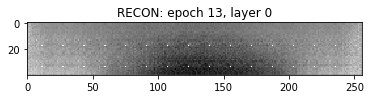

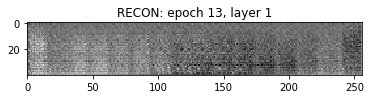

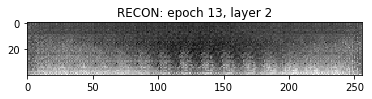



EPOCH : 14




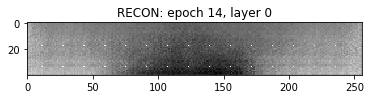

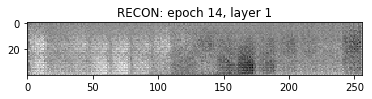

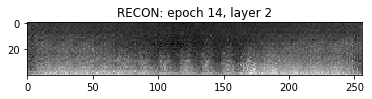



EPOCH : 15




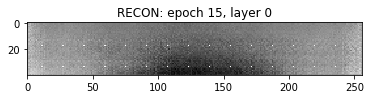

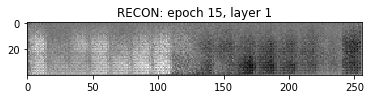

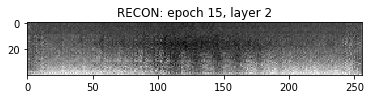



EPOCH : 16




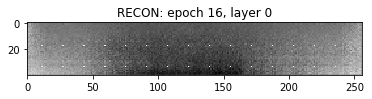

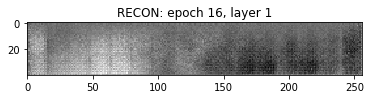

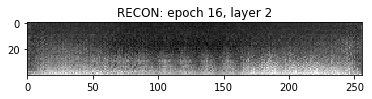



EPOCH : 17




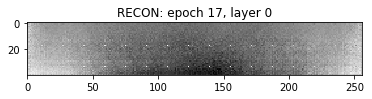

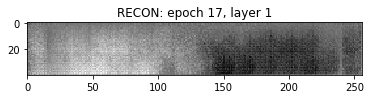

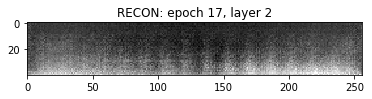



EPOCH : 18




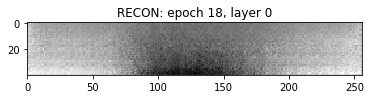

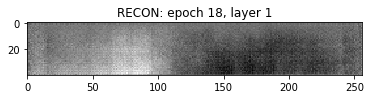

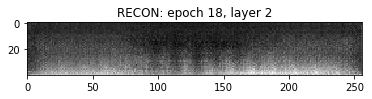



EPOCH : 19




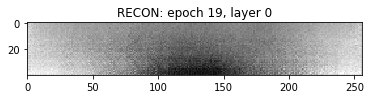

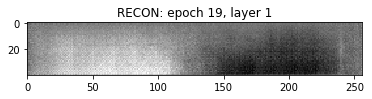

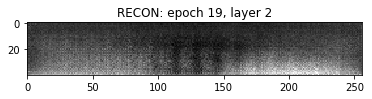



EPOCH : 20




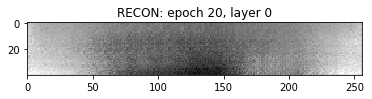

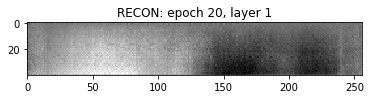

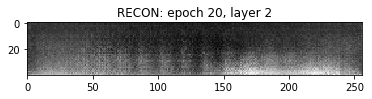



EPOCH : 21




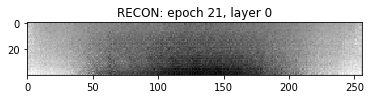

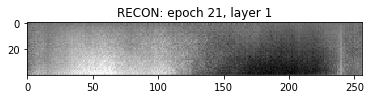

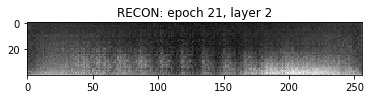



EPOCH : 22




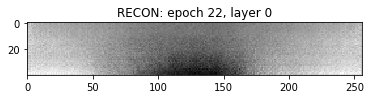

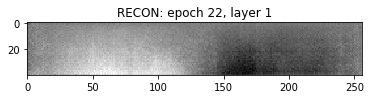

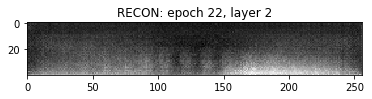



EPOCH : 23




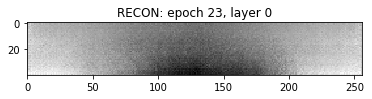

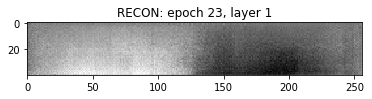

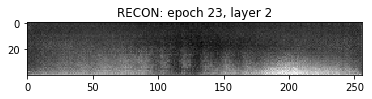



EPOCH : 24




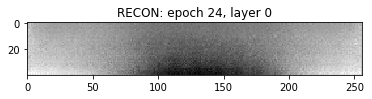

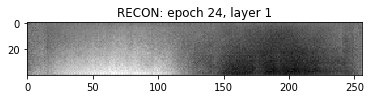

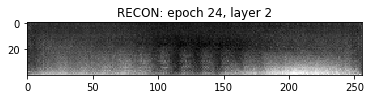



EPOCH : 25




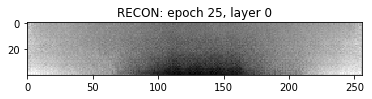

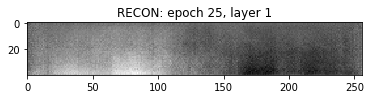

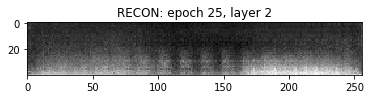



EPOCH : 26




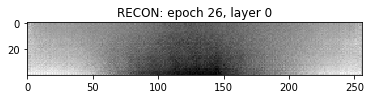

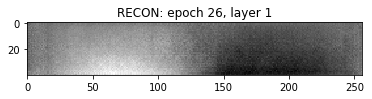

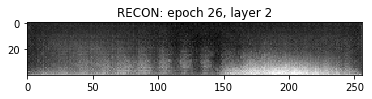



EPOCH : 27




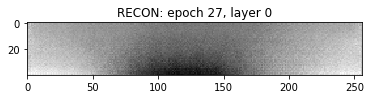

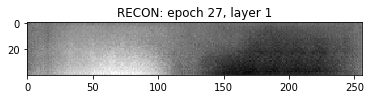

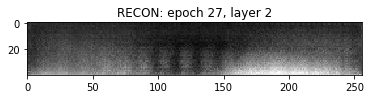



EPOCH : 28




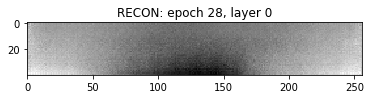

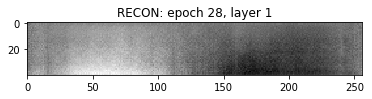

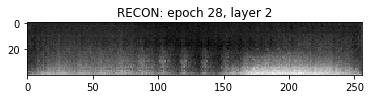



EPOCH : 29




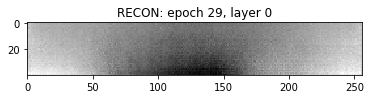

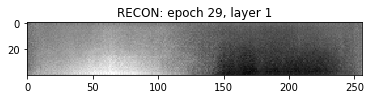

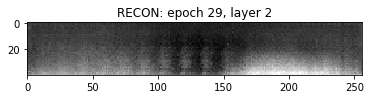

In [302]:
print('loading data')
names = ['lidar_val.npz','lidar_val.npz']
#val length: 152
batch_size=5
loader = DataLoader(load_polar(names[0])[:100]
                    , batch_size = batch_size, shuffle=True, drop_last=True) 
print(' ')
lidar = batch.numpy()
for i in range(3):
    title = 'TRUTH: epoch %d, layer %d'%(epoch, i)
    #plt.subplot(1,3,i+1)
    plt.imshow(lidar[0,i,:,:], cmap=cm.gray)
    plt.title(title)
    #plt.gcf().set_size_inches(16,16)
    #plt.tight_layout
    plt.show()
del lidar


#the vae trains the convolution layers
network_encode = VAE_encode(batch_size)
network_decode = VAE_decode(batch_size)
lr = 0.00005 #this should prevent the over
solver_encode = optim.Adam(network_encode.parameters(), lr=lr/2)
solver_decode = optim.Adam(network_decode.parameters(), lr=lr*2)
#network.eval() #changes batch normalization behavior

encoder_loss = []
decoder_loss = []

epochs = 30
for epoch in range(epochs):
    print('\n\nEPOCH : %d\n\n'%epoch)
    for batch in loader:        
        ## ENCODE STEP
        solver_encode.zero_grad()
        z, mu, logvar = network_encode(batch, batch_size, training=1)
        loss1 = KLloss(mu,logvar)
        loss1.backward(retain_graph=True)
        solver_encode.step()
        
        ## DECODE STEP
        solver_decode.zero_grad()
        pred = network_decode(z, batch_size)
        loss2 = MSEloss(pred, batch)
        loss2.backward()
        solver_decode.step()

    encoder_loss.append(loss1)
    decoder_loss.append(loss2)
    
    #Print image comparisons 

    #z, mu, logvar = network_encode(batch, batch_size, training=0) #non-sample
    #pred = network_decode(z, batch_size)
    lidar = pred.clone().detach().numpy()
    for i in range(3):
        title = 'RECON: epoch %d, layer %d'%(epoch, i)
        #plt.subplot(1,3,i+1)
        plt.imshow(lidar[0,i,:,:], cmap=cm.gray)
        plt.title(title)
        #plt.gcf().set_size_inches(16,16)
        #plt.tight_layout
        plt.show()
    del lidar




## Plot

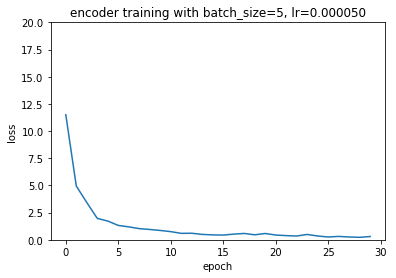

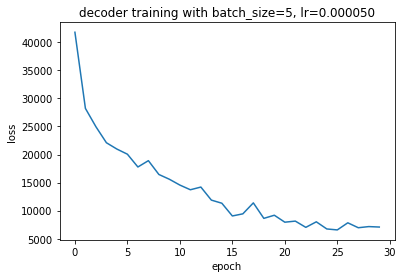

In [304]:
encoder_loss = np.array(encoder_loss)
decoder_loss = np.array(decoder_loss)

plt.plot(range(len(encoder_loss)),encoder_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim((0,20))
plt.title('encoder training with batch_size=%d, lr=%f'%(batch_size,lr))
plt.show()
#plt.savefig('training_loss.png')

plt.plot(range(len(decoder_loss)),decoder_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
#plt.ylim((0,1))
plt.title('decoder training with batch_size=%d, lr=%f'%(batch_size,lr))
plt.show()
#plt.savefig('training_loss.png')